# **Corporate Bankruptcy Prediction with Machine Learning**

  propose to predict corporate bankruptcy after 30 and 90 days as a function of a company’s operating margins, net gross rate, debt, and other financial ratios.

---



# **Imports**

In [ ]:
!pip install --upgrade gdown

In [ ]:
import gdown
import random
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from numpy.linalg import *
from scipy.spatial import distance
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
import seaborn as sns
np.random.seed(42)
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV

import base64
import datetime

# **Exploratory Data Analysis**

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d utkarshx27/american-companies-bankruptcy-prediction-dataset
!unzip -q american-companies-bankruptcy-prediction-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset
License(s): CC0-1.0
american-companies-bankruptcy-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace american_bankruptcy.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
data = pd.read_csv('/content/american_bankruptcy.csv')
data.describe()

,year,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
count,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,7.868200e+04,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
mean,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,3.414355e+03,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,1.841410e+04,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,1.000000e-04,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,3.498000e+01,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,2.275118e+02,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,1.244890e+03,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250
max,2018.000000,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


In [ ]:
data.rename(columns = {
    "status_label": "bankrupt",
    "X1": "Current Assets",
    "X2": "Cost of Goods Sold",
    "X3": "Depreciation and Amortization",
    "X4": "EBITDA",
    "X5": "Inventory",
    "X7": "Total Receivables",
    "X8": "Market Value",
    "X9": "Net Sales",
    "X10": "Total assets",
    "X11": "Total Long-term debt",
    "X12": "EBIT",
    "X13": "Gross Profit",
    "X14": "Total Current Liabilities",
    "X15": "Retained Earnings",
    "X16": "Total Revenue",
    "X17": "Total Liabilities",
    "X18": "Total Operating Expenses"
}, inplace = True)

In [ ]:
data.loc[data["bankrupt"] == "alive", 'bankrupt'] = 0
data.loc[data['bankrupt'] == 'failed', 'bankrupt'] = 1
data['bankrupt'] = data['bankrupt'].astype(int)
data.drop(columns=['company_name'], inplace=True)

# Financial ratios
data['gross_profit_margin'] = data['Gross Profit'] / data['Net Sales']
data['current_ratio'] = data['Current Assets'] / data['Total Current Liabilities']
data['debt_to_equity_ratio'] = data['Total Long-term debt'] / data['Net Sales']

# Relative measures
data['market_value_to_total_assets'] = data['Market Value'] / data['Total assets']
data['net_sales_to_total_revenue'] = data['Net Sales'] / data['Total Revenue']

# Growth rates
data['revenue_growth_rate'] = data['Net Sales'].pct_change()
data['ebit_growth_rate'] = data['EBIT'].pct_change()

# Moving averages
data['inventory_rolling_mean_3'] = data['Inventory'].rolling(window=3).mean()
data['receivables_rolling_mean_3'] = data['Total Receivables'].rolling(window=3).mean()
data['inventory_rolling_mean_30'] = data['Inventory'].rolling(window=30).mean()
data['receivables_rolling_mean_30'] = data['Total Receivables'].rolling(window=30).mean()

# Altman Z-Score Components
data['working_capital_to_total_assets'] = (data['Current Assets'] - data['Total Current Liabilities']) / data['Total assets']
data['retained_earnings_to_total_assets'] = data['Retained Earnings'] / data['Total assets']
data['ebit_to_total_assets'] = data['EBIT'] / data['Total assets']

data['sales_to_total_assets'] = data['Net Sales'] / data['Total assets']
data['cash_flow_coverage_ratio'] = data['EBITDA'] / data['Total Long-term debt']

# Leverage and Coverage Ratios
data['debt_to_equity_ratio'] = data['Total Long-term debt'] / data['Net Sales']

In [ ]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
data.head()

,bankrupt,year,Current Assets,Cost of Goods Sold,Depreciation and Amortization,EBITDA,Inventory,X6,Total Receivables,Market Value,...,ebit_growth_rate,inventory_rolling_mean_3,receivables_rolling_mean_3,inventory_rolling_mean_30,receivables_rolling_mean_30,working_capital_to_total_assets,retained_earnings_to_total_assets,ebit_to_total_assets,sales_to_total_assets,cash_flow_coverage_ratio
29,0,2009,900.200,600.500,66.400,84.700,131.100,-474.300,200.300,805.6440,...,-0.798680,154.666667,221.533333,346.666700,225.599567,0.494344,-0.728863,0.013620,0.741813,0.130108
30,0,2010,1107.700,677.200,61.500,121.400,106.400,62.000,252.500,1231.5240,...,2.273224,133.400000,231.133333,339.012767,229.737967,0.555443,-0.622855,0.040624,0.784401,0.186540
31,0,1999,9.757,19.796,0.667,-0.265,5.494,-2.207,3.924,3.2449,...,-1.015559,80.998000,152.241333,328.509567,226.029200,0.497140,-0.455813,-0.066638,2.099957,-0.044359
32,0,2000,7.884,16.506,0.700,0.672,4.078,-0.808,3.244,4.5428,...,-0.969957,38.657333,86.556000,319.092567,223.553067,0.482943,-0.618884,-0.002412,2.185303,0.137846
33,0,2001,6.494,15.700,0.761,0.381,3.488,-1.738,2.677,2.9667,...,12.571429,4.353333,3.281667,310.543700,221.431567,0.515229,-1.033237,-0.044007,2.785292,0.098373


In [ ]:
data_sorted = data.sort_values(by='year')
train_end_year = 2011 # given from dataset
val_end_year = 2014 # given from dataset

train_data = data_sorted[data_sorted['year'] <= train_end_year]
val_data = data_sorted[(data_sorted['year'] > train_end_year) & (data_sorted['year'] <= val_end_year)]
test_data = data_sorted[data_sorted['year'] > val_end_year]

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

train_data = train_data.apply(pd.to_numeric, errors='coerce')
val_data = val_data.apply(pd.to_numeric, errors='coerce')
test_data = test_data.apply(pd.to_numeric, errors='coerce')

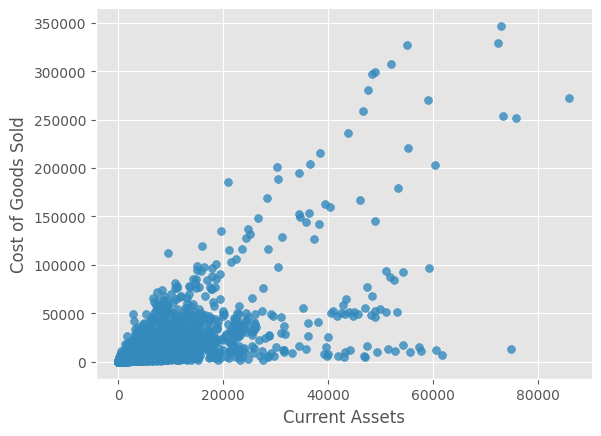

In [ ]:
# @title Current Assets vs Cost of Goods Sold
from matplotlib import pyplot as plt
train_data.plot(kind='scatter', x='Current Assets', y='Cost of Goods Sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

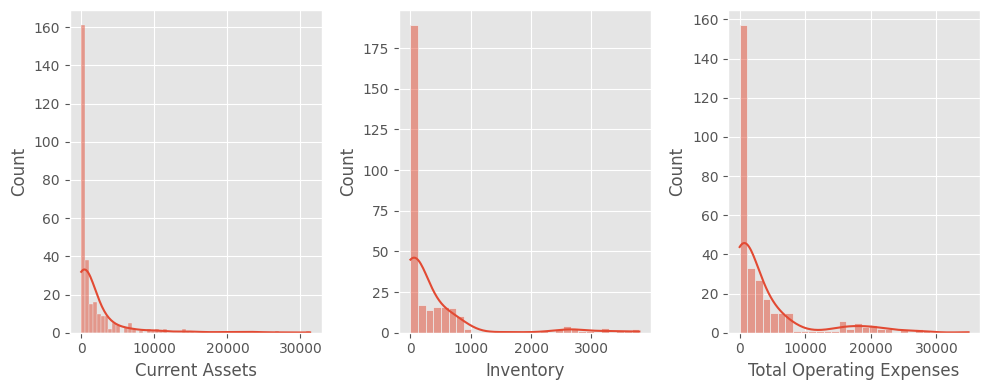

In [ ]:
# @title Distribution of Assets, Inventory, and Operating Expenses
plt.figure(figsize=(10, 4))
for i, feature in enumerate(['Current Assets', 'Inventory', 'Total Operating Expenses']):
    if train_data[feature].dtype == 'float64':
        x = plt.subplot(1,3,i+1)
        sns.histplot(data[feature][:300], kde=True)
        plt.xlabel(feature)
plt.tight_layout()
plt.show()

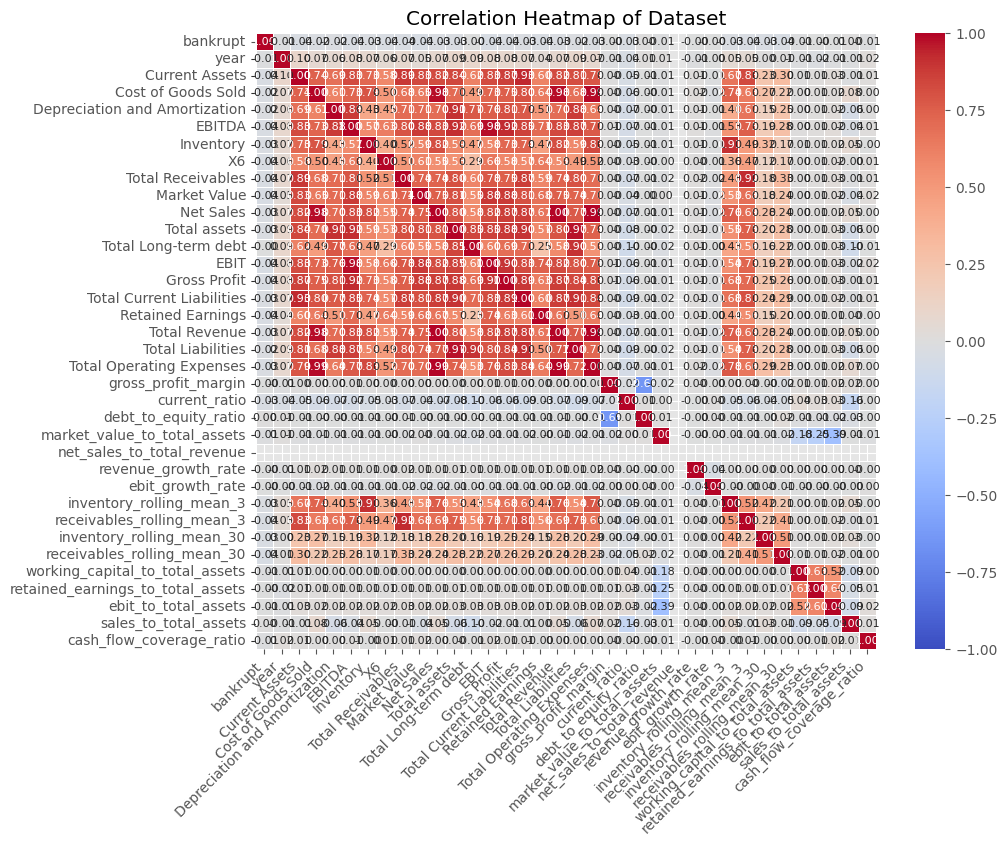

In [ ]:
correlation_matrix = train_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            annot_kws={"size": 8},
            linewidths=.5,
            vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Dataset')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

Through the above heatmap, we can see that a large number of our features are highly correlated. Specifically, revenue and net sales, sales and costs of goods sold, and EBIDTA and assets. Thus, we will attempt to remove correlated features through feature reduction.

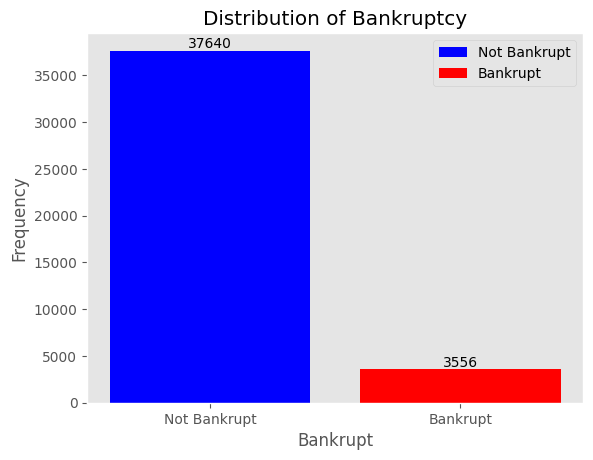

In [ ]:
# @title Distribution of Target Label
counts = train_data['bankrupt'].value_counts()
bars = plt.bar(['Not Bankrupt', 'Bankrupt'], counts, color=['blue', 'red'])
plt.xlabel('Bankrupt')
plt.ylabel('Frequency')
plt.title('Distribution of Bankruptcy')
plt.legend(bars, ['Not Bankrupt', 'Bankrupt'])
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             count,
             ha='center', va='bottom')
plt.grid(False)
plt.show()

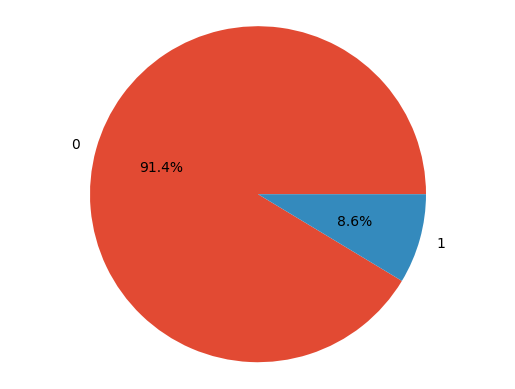

In [ ]:
labels = train_data['bankrupt'].astype('category').cat.categories.tolist()
counts = train_data['bankrupt'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False) #autopct is show the % on plot
ax1.axis('equal')
plt.show();

Through the above two graphs, it is easily apparent that our dataset is imbalanced with respect to our target label. Specifically, over 92% of our data shows no bankruptcy in the following year.

# **Resampling to Rebalance Dataset**

Here, we attempt to rebalance the target label, through an approach found in our research, the Synthetic Minority Oversampling Technique (SMOTE).

In [ ]:
y_train = train_data['bankrupt']
X_train = train_data.drop(columns=['bankrupt'])
y_val = val_data['bankrupt']
X_val = val_data.drop(columns=['bankrupt'])
y_test = test_data['bankrupt']
X_test = test_data.drop(columns=['bankrupt'])

In [ ]:
smote = SMOTE(random_state=42, sampling_strategy=0.5)

# # Apply SMOTE to over-sample the minority class
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print(y_train_resampled.value_counts())

bankrupt
0    37640
1    18820
Name: count, dtype: int64


# **Feature Importance**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape

(56460, 35)

In [ ]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train_resampled)

logistic_coef = logistic_model.coef_[0]

random_forest = RandomForestClassifier()

rfe = RFE(estimator=random_forest, step=4)
rfe.fit(X_train_scaled, y_train_resampled)

# Get ranking of features
rfe_ranking = rfe.ranking_

feature_importance_data = pd.DataFrame({
    'Feature': X_train.columns,
    'Logistic Coef': logistic_coef,
    'RFE Ranking': rfe_ranking
})

feature_importance_data = feature_importance_data.reindex(
    feature_importance_data['Logistic Coef'].abs().sort_values(ascending=False).index
)

<ipython-input-21-0ce803329b6d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_data, x='Logistic Coef', y='Feature', palette='viridis')


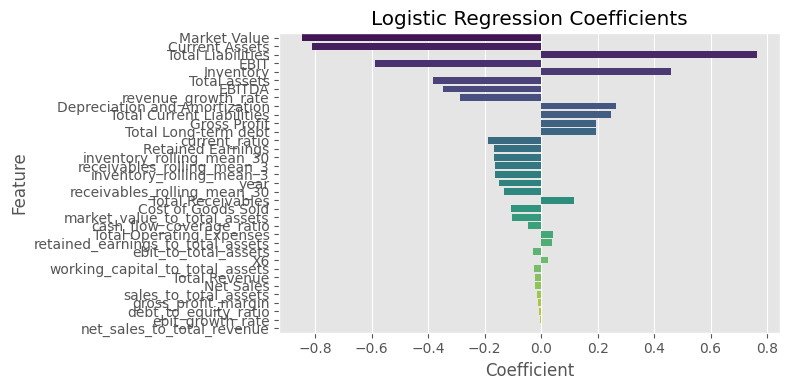

<ipython-input-21-0ce803329b6d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_data, x='RFE Ranking', y='Feature', palette='viridis')


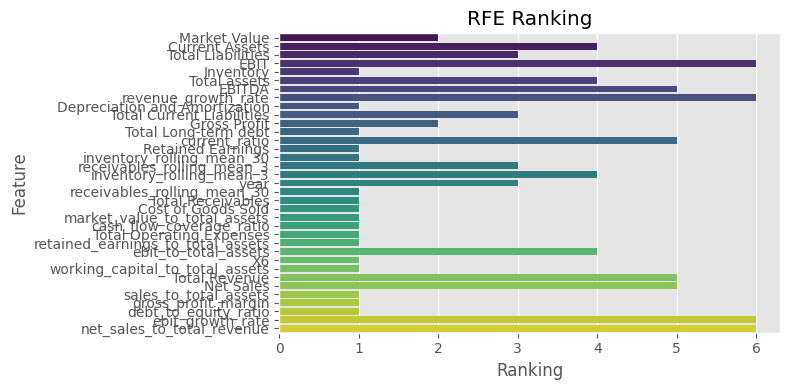

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance_data, x='Logistic Coef', y='Feature', palette='viridis')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.ylabel('Feature')
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance_data, x='RFE Ranking', y='Feature', palette='viridis')
plt.title('RFE Ranking')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# **Principal Component Analysis**

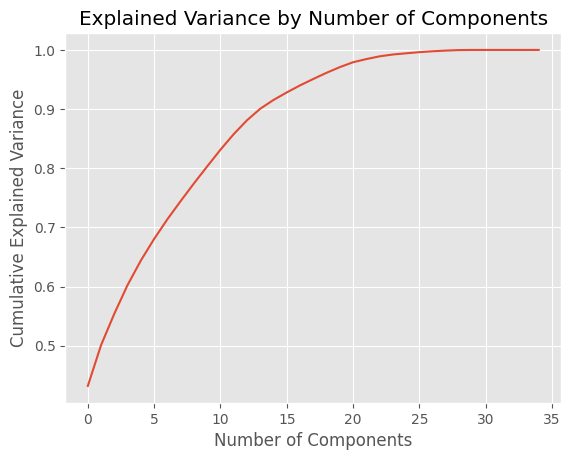

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.show()

In [ ]:
desired_variance = 0.95  # aiming to retain 80% of the variance
num_components = np.argmax(cumulative_variance >= desired_variance) + 1
print("Number of components to retain {:.2f}% of the variance: {}".format(desired_variance * 100, num_components))

Number of components to retain 95.00% of the variance: 18


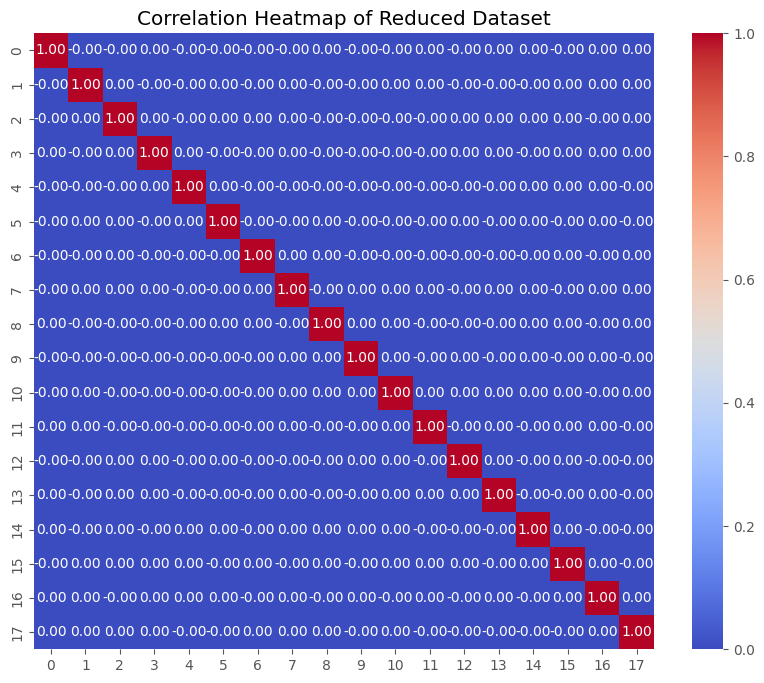

In [ ]:
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

correlation_matrix = np.corrcoef(X_train_pca.T)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap of Reduced Dataset')
plt.show()

In [ ]:
log_reg = LogisticRegression(solver='liblinear')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_pca, y_train_resampled)
best_params = grid_search.best_params_
print(best_params)

log_reg_tuned = LogisticRegression(**best_params, max_iter=1000)
log_reg_tuned.fit(X_train_pca, y_train_resampled)

y_val_pred = log_reg_tuned.predict(X_val_pca)
roc_auc_val = roc_auc_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)

print("Logistic Regression Evaluation on Validation Set:")
print("ROC-AUC:", roc_auc_val)
print("F1 Score:", f1_val)
print("Recall Score:", recall_val)

{'C': 100, 'penalty': 'l2'}
Logistic Regression Evaluation on Validation Set:
ROC-AUC: 0.5077454033100163
F1 Score: 0.04044943820224719
Recall Score: 0.023872679045092837


In [ ]:
log_reg_original = LogisticRegression()
log_reg_original.fit(X_train_resampled, y_train_resampled)
y_val_pred_original = log_reg_original.predict(X_val)
roc_auc_val_original = roc_auc_score(y_val, y_val_pred_original)
f1_val_original = f1_score(y_val, y_val_pred_original)
recall_val_original = recall_score(y_val, y_val_pred_original)

print("Logistic Regression Evaluation on Untransformed Validation Set:")
print("ROC-AUC:", roc_auc_val_original)
print("F1 Score:", f1_val_original)
print("Recall Score:", recall_val_original)

Logistic Regression Evaluation on Untransformed Validation Set:
ROC-AUC: 0.5361894303921727
F1 Score: 0.12877263581488935
Recall Score: 0.08488063660477453


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
svm = SVC(kernel='rbf', probability=True)

param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
}

grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='roc_auc')
grid_search_svm.fit(X_train_pca, y_train_resampled)

best_params_svm = grid_search_svm.best_params_
print(best_params_svm)

best_svm = SVC(**best_params_svm, probability=True)
best_svm.fit(X_train_pca, y_train_resampled)
y_val_pred_svm = best_svm.predict(X_val_pca)

roc_auc_val_svm = roc_auc_score(y_val, y_val_pred_svm)
f1_val_svm = f1_score(y_val, y_val_pred_svm)
recall_val_svm = recall_score(y_val, y_val_pred_svm)

print("Support Vector Machine (SVM) Evaluation on Validation Set:")
print("ROC-AUC:", roc_auc_val_svm)
print("F1 Score:", f1_val_svm)
print("Recall Score:", recall_val_svm)

In [ ]:
gradient_boosting = GradientBoostingClassifier()

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
}

grid_search_gb = GridSearchCV(gradient_boosting, param_grid_gb, cv=3, scoring='roc_auc')
grid_search_gb.fit(X_train_resampled, y_train_resampled)

best_params_gb = grid_search_gb.best_params_
print(best_params_gb)

best_gb = GradientBoostingClassifier(**best_params_gb)
best_gb.fit(X_train_resampled, y_train_resampled)
y_val_pred_gb = best_gb.predict(X_val)

roc_auc_val_gb = roc_auc_score(y_val, y_val_pred_gb)
f1_val_gb = f1_score(y_val, y_val_pred_gb)
recall_val_gb = recall_score(y_val, y_val_pred_gb)

print("Gradient Boosting Classifier Evaluation on Validation Set:")
print("ROC-AUC:", roc_auc_val_gb)
print("F1 Score:", f1_val_gb)
print("Recall Score:", recall_val_gb)


In [ ]:
random_forest = RandomForestClassifier()

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
}

grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=3, scoring='roc_auc')
grid_search_rf.fit(X_train_pca, y_train_resampled)

best_params_rf = grid_search_rf.best_params_
print(best_params_rf)

best_rf = RandomForestClassifier(**best_params_rf)
best_rf.fit(X_train_pca, y_train_resampled)
y_val_pred_rf = best_rf.predict(X_val_pca)

roc_auc_val_rf = roc_auc_score(y_val, y_val_pred_rf)
f1_val_rf = f1_score(y_val, y_val_pred_rf)
recall_val_rf = recall_score(y_val, y_val_pred_rf)

print("Random Forest Classifier Evaluation on Validation Set:")
print("ROC-AUC:", roc_auc_val_rf)
print("F1 Score:", f1_val_rf)
print("Recall Score:", recall_val_rf)

In [ ]:
#full_scaled_svm = SVC(C = 10, kernel='rbf', probability=True, gamma='auto')
#full_scaled_svm.fit(X_train_resampled, y_train_resampled)
#y_test_pred_svm = full_scaled_svm.predict(X_test_scaled)

roc_auc_test_svm = roc_auc_score(y_test, y_test_pred_svm)
f1_test_svm = f1_score(y_test, y_test_pred_svm)
recall_test_svm = recall_score(y_test, y_test_pred_svm)
acc_test_svm = np.sum([y_test == y_test_pred_svm])/len(y_test)

print("Support Vector Machine (SVM) Evaluation on Test Set:")
print("ROC-AUC:", roc_auc_test_svm)
print("F1 Score:", f1_test_svm)
print("Recall Score:", recall_test_svm)
print('Test Accuracy:', acc_test_svm)

In [ ]:
full_scaled_gb = GradientBoostingClassifier(learning_rate=1, max_depth=7, n_estimators=200)
full_scaled_gb.fit(X_train_scaled, y_train_resampled)
y_test_pred_gb = full_scaled_gb.predict(X_test_scaled)

roc_auc_test_gb = roc_auc_score(y_test, y_test_pred_gb)
f1_test_gb = f1_score(y_test, y_test_pred_gb)
recall_test_gb = recall_score(y_test, y_test_pred_gb)
acc_test_gb = np.sum([y_test == y_test_pred_gb])/len(y_test)

print("Gradient Boosting Classifier Evaluation on Test Set:")
print("ROC-AUC:", roc_auc_test_gb)
print("F1 Score:", f1_test_gb)
print("Recall Score:", recall_test_gb)
print('Test Accuracy:', acc_test_gb)

In [ ]:
full_scaled_rf = RandomForestClassifier(n_estimators = 75)
full_scaled_rf.fit(X_train_pca, y_train_resampled)
y_test_pred_rf = full_scaled_rf.predict(X_test_pca)

roc_auc_test_rf = roc_auc_score(y_test, y_test_pred_rf)
f1_test_rf = f1_score(y_test, y_test_pred_rf)
recall_test_rf = recall_score(y_test, y_test_pred_rf)
acc_test_rf = np.sum([y_test == y_test_pred_rf])/len(y_test)

print("Random Forest Classifier Evaluation on Test Set:")
print("ROC-AUC:", roc_auc_test_rf)
print("F1 Score:", f1_test_rf)
print("Recall Score:", recall_test_rf)
print('Test Accuracy:', acc_test_rf)

In [ ]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(32, activation='relu', input_shape = (X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_acc}')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc

y_pred = (model.predict(X_test_scaled) > 0.5).astype('int32')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test_scaled))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
roc_auc_test_nn = roc_auc_score(y_test, y_pred)
f1_test_nn = f1_score(y_test, y_pred)
recall_test_nn = recall_score(y_test, y_pred)
acc_test_nn = np.sum([y_test == y_pred[:,0]])/len(y_test)

print("Neural Network Classifier Evaluation on Test Set:")
print("ROC-AUC:", roc_auc_test_nn)
print("F1 Score:", f1_test_nn)
print("Recall Score:", recall_test_nn)
print('Test Accuracy:', acc_test_nn)